## MonoForce Inference with ROUGH Data

We are going to load the ROUGH data and perform inference with the pretrained MonoForce model.

In [1]:
# add the path to the source code of the MonoForce package
import sys
sys.path.append('../src')

### Load the Terrain Encoder model

In [2]:
import torch
from monoforce.models.terrain_encoder.lss import compile_model

def load_model(model_path):
    """
    Load the MonoForce model from a given path.
    :param model_path: str, path to the model
    :param robot: str, robot type
    :return: MonoForce model
    """
    lss_cfg_path = f'../config/lss_cfg.yaml'
    lss_cfg = read_yaml(lss_cfg_path)
    
    model = compile_model(lss_cfg['grid_conf'], lss_cfg['data_aug_conf'])
    
    # https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113/3
    model_dict = model.state_dict()
    pretrained_model = torch.load(model_path)
    print(f"Loading pretrained LSS model from {model_path}")
    model_dict.update(pretrained_model)
    model.load_state_dict(model_dict)
    model.eval()
    
    return model

/home/ruslan/miniconda3/envs/mf/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


### Weights
The pretrained model weights could be downloaded from [Google Drive](https://drive.google.com/drive/folders/1n0KoUEQ0FIznf-qMKshk0C956CJenIhd?usp=drive_link)

In [3]:
from monoforce.utils import read_yaml

model_path = f'../config/weights/lss/lss.pt'
model = load_model(model_path)
# print(model)

Loaded pretrained weights for efficientnet-b0
Loading pretrained LSS model from ../config/weights/lss/lss.pt


In [4]:
import os
import numpy as np
from monoforce.datasets import ROUGH, rough_seq_paths
from monoforce.dphys_config import DPhysConfig

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
def compile_data(seq_i=None, robot='tradr', small=False, is_train=False):
    """
    Compile the ROUGH dataset for a given sequence index and robot type.
    :param seq_i: int, sequence index
    :param robot: str, robot type
    :param small: bool, if True, return a small subset of the dataset
    :param is_train: bool, if True, return the training set, otherwise the test set
    :return: ROUGH dataset
    """
    dphys_cfg = DPhysConfig(robot=robot)

    lss_cfg_path = f'../config/lss_cfg.yaml'
    assert os.path.isfile(lss_cfg_path)
    lss_cfg = read_yaml(lss_cfg_path)

    if seq_i is not None:
        path = rough_seq_paths[seq_i]
    else:
        path = np.random.choice(rough_seq_paths)

    ds = ROUGH(path=path, dphys_cfg=dphys_cfg, lss_cfg=lss_cfg, is_train=is_train)
    if small:
        ds = ds[np.random.choice(len(ds), 4, replace=False)]

    return ds

In [6]:
robot = 'marv'
ds = compile_data(seq_i=1, robot=robot, small=False, is_train=False)
print(f"Number of samples: {len(ds)}")

Number of samples: 335


### Visualizing a sample from the dataset.

In [7]:
from monoforce.utils import position

i = np.random.choice(len(ds))
print(f"Sample index: {i}")
sample = ds[i]
points = torch.as_tensor(position(ds.get_cloud(i))).T
sample = sample + (points,)
(imgs, rots, trans, intrins, post_rots, post_trans,
 hm_terrain,
 control_ts, controls,
 traj_ts, Xs, Xds, Rs, Omegas, points) = sample
print(f"Images shape: {imgs.shape}")
print(f"Extrinsic Rotations shape: {rots.shape}")
print(f"Extrinsic Translations shape: {trans.shape}")
print(f"Intrinsic camera matrix shape: {intrins.shape}")
print(f"Images augmentation Post-rotation shape: {post_rots.shape}")
print(f"Images augmentation Post-translation shape: {post_trans.shape}")
print(f"Heightmap terrain shape: {hm_terrain.shape}")
print(f"Control timestamps shape: {control_ts.shape}")
print(f"Controls shape: {controls.shape}")
print(f"Trajectory timestamps shape: {traj_ts.shape}")
print(f"Robot's positions shape: {Xs.shape}")
print(f"Robot's linear velocities shape: {Xds.shape}")
print(f"Robot's orientations shape: {Rs.shape}")
print(f"Robot's angular velocities shape: {Omegas.shape}")
print(f"Lidar points shape: {points.shape}")

Sample index: 203
Images shape: torch.Size([4, 3, 256, 416])
Extrinsic Rotations shape: torch.Size([4, 3, 3])
Extrinsic Translations shape: torch.Size([4, 3])
Intrinsic camera matrix shape: torch.Size([4, 3, 3])
Images augmentation Post-rotation shape: torch.Size([4, 3, 3])
Images augmentation Post-translation shape: torch.Size([4, 3])
Heightmap terrain shape: torch.Size([2, 128, 128])
Control timestamps shape: (500,)
Controls shape: (500, 2)
Trajectory timestamps shape: (10,)
Robot's positions shape: (10, 3)
Robot's linear velocities shape: (10, 3)
Robot's orientations shape: (10, 3, 3)
Robot's angular velocities shape: (10, 3)
Lidar points shape: torch.Size([3, 91359])


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from monoforce.models.terrain_encoder.utils import ego_to_cam, get_only_in_img_mask, denormalize_img


def explore_data(sample: list, raw_img_size: tuple, model: torch.nn.Module):
    """
    Explore the ROUGH data sample.
    :param sample: list, sample from the dataset
    :param raw_img_size: tuple, raw image size
    :param model: torch.nn.Module, MonoForce model
    """
    H, W = raw_img_size
    (imgs, rots, trans, intrins, post_rots, post_trans,
     hm_terrain,
     control_ts, controls,
     traj_ts, Xs, Xds, Rs, Omegas,
     points) = sample
    height_terrain, mask_terrain = hm_terrain[0], hm_terrain[1]
    n_cams = len(imgs)

    frustum_pts = model.get_geometry(rots[None], trans[None], intrins[None], post_rots[None], post_trans[None])
    frustum_pts = frustum_pts.squeeze(0)

    n_rows, n_cols = 2, int(np.ceil(n_cams / 2) + 2)
    ratio = H / W
    plt.figure(figsize=(n_cols * 3, n_rows * 3 * ratio))
    gs = mpl.gridspec.GridSpec(n_rows, n_cols)
    gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

    final_ax = plt.subplot(gs[:, -1:])
    plt.title('Frustum Points')
    for imgi, img in enumerate(imgs):
        cam_pts = ego_to_cam(points, rots[imgi], trans[imgi], intrins[imgi])
        mask = get_only_in_img_mask(cam_pts, H, W)
        plot_pts = post_rots[imgi].matmul(cam_pts) + post_trans[imgi].unsqueeze(1)

        ax = plt.subplot(gs[imgi // int(np.ceil(n_cams / 2)), imgi % int(np.ceil(n_cams / 2))])
        plt.imshow(denormalize_img(img))
        plt.scatter(plot_pts[0, mask], plot_pts[1, mask], c=points[2, mask],
                    s=1, alpha=0.4, cmap='jet', vmin=-1., vmax=1.)
        plt.axis('off')
        
        plt.sca(final_ax)
        plt.plot(frustum_pts[imgi, :, :, :, 0].view(-1), frustum_pts[imgi, :, :, :, 1].view(-1), '.')

    ax = plt.subplot(gs[:, -2:-1])
    plt.imshow(height_terrain.T, origin='lower', cmap='jet', vmin=-1., vmax=1.)
    plt.title('Heightmap Terrain')
    plt.axis('off')
    
    final_ax.set_aspect('equal')

    plt.show()

Raw image shape: (1200, 1920)


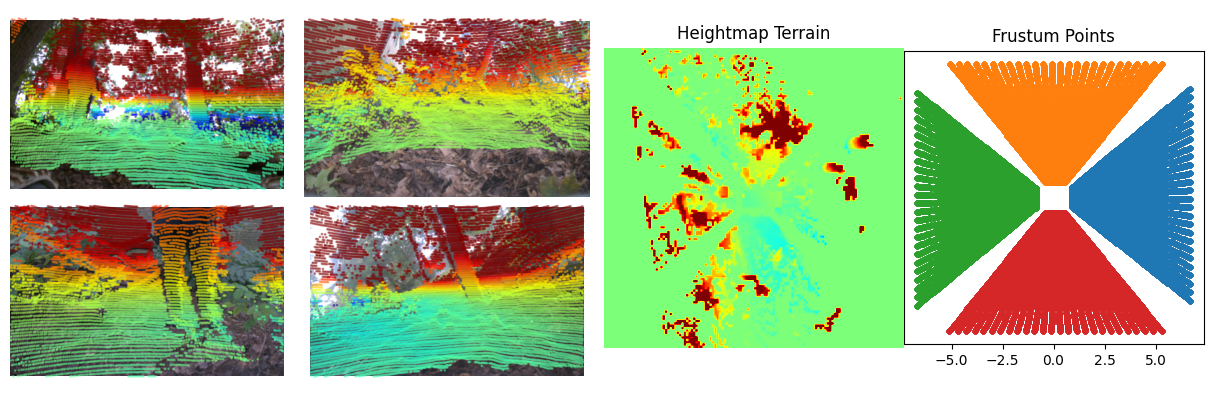

In [9]:
raw_img_shape = ds.lss_cfg['data_aug_conf']['H'], ds.lss_cfg['data_aug_conf']['W']
print(f"Raw image shape: {raw_img_shape}")

explore_data(sample, raw_img_size=raw_img_shape, model=model)

### Inference with the MonoForce model

In [10]:
from timeit import default_timer as timer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

batch = [torch.as_tensor(s, device=device).unsqueeze(0) for s in sample]
(imgs, rots, trans, intrins, post_rots, post_trans,
 hm_terrain,
 control_ts, controls,
 traj_ts, Xs, Xds, Rs, Omegas,
 points) = batch

start = timer()
with torch.inference_mode():
    inputs = [imgs, rots, trans, intrins, post_rots, post_trans]
    out = model(*inputs)
end = timer()

heightmap_terrain = out['terrain']
friction = out['friction']
print(f"Heightmap terrain shape: {heightmap_terrain.shape}")
print(f"Friction shape: {friction.shape}")
print(f"Time taken for inference: {end - start} seconds")
print(f"Device: {list(model.parameters())[0].device}")

Heightmap terrain shape: torch.Size([1, 1, 128, 128])
Friction shape: torch.Size([1, 1, 128, 128])
Time taken for inference: 1.6164402829999744 seconds
Device: cuda:0


### Visualizing the predicted heightmap

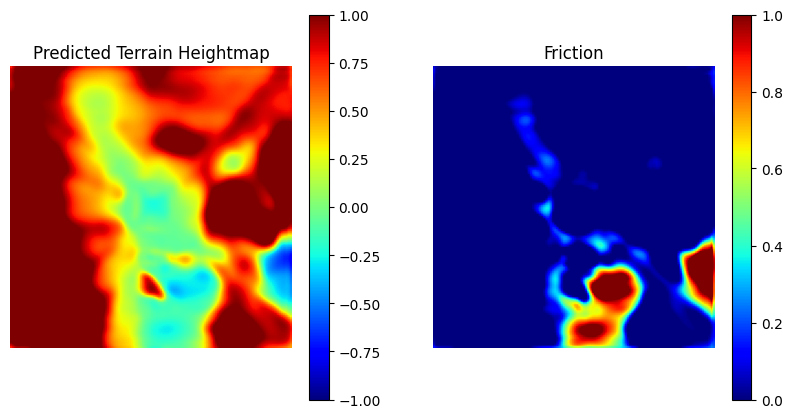

In [11]:
heightmap_terrain_np = heightmap_terrain.squeeze().cpu().numpy()
friction_np = friction.squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(heightmap_terrain_np.T, origin='lower', cmap='jet', vmin=-1., vmax=1.)
plt.title('Predicted Terrain Heightmap')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(friction_np.T, origin='lower', cmap='jet', vmin=0, vmax=1)
plt.title('Friction')
plt.axis('off')
plt.colorbar()

plt.show()

## Predicting robot's trajectory with $\nabla$Physics

Control inputs could have the following format:
- Left and right velocity commands: $v_l = v_r = 1$ m/s
- Simulation time: $T = 5$ s
- Simulation step: $\Delta t = 0.01$ s

In [12]:
from monoforce.models.dphysics import DPhysics

dphys_cfg = DPhysConfig(robot=robot)
dphysics = DPhysics(dphys_cfg=dphys_cfg, device=device)

with torch.inference_mode():
    states, forces = dphysics(z_grid=heightmap_terrain.squeeze(1), controls=controls)

In [13]:
Xs, Rs, Xds, Omegas, X_points = states
print(f"Robot's positions shape: {Xs.shape}")
print(f"Robot's orientation shape: {Rs.shape}")
print(f"Linear velocity shape: {Xds.shape}")
print(f"Angular velocity shape: {Omegas.shape}")
print(f"Robot's body points shape: {X_points.shape}")

Robot's positions shape: torch.Size([1, 500, 3])
Robot's orientation shape: torch.Size([1, 500, 3])
Linear velocity shape: torch.Size([1, 500, 3, 3])
Angular velocity shape: torch.Size([1, 500, 3])
Robot's body points shape: torch.Size([1, 500, 223, 3])


### Visualizing the robot's trajectory and heightmap

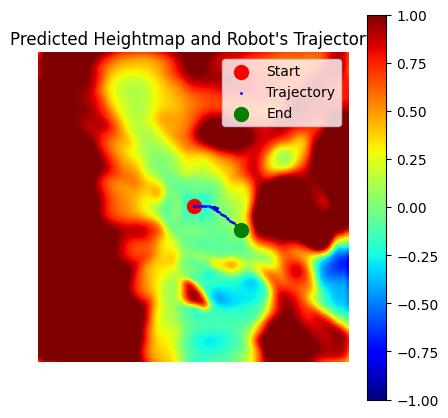

In [14]:
xs_grid = Xs.cpu().numpy()
xs_grid = xs_grid.reshape(-1, 3)
xs_grid = xs_grid[::10]  # downsample for visualization
xs_grid = (xs_grid[:, :2] + dphys_cfg.d_max) / dphys_cfg.grid_res  # normalize to grid resolution

for b in range(Xs.shape[0]):
    plt.figure(figsize=(5, 5))
    plt.imshow(heightmap_terrain_np.T, origin='lower', cmap='jet', vmin=-1., vmax=1.)
    plt.title('Predicted Heightmap and Robot\'s Trajectory')
    plt.axis('off')
    plt.colorbar()
    plt.scatter(xs_grid[0, 0], xs_grid[0, 1], c='red', s=100, label='Start')
    plt.scatter(xs_grid[:, 0], xs_grid[:, 1], c='blue', s=1, label='Trajectory')
    plt.scatter(xs_grid[-1, 0], xs_grid[-1, 1], c='green', s=100, label='End')
    plt.legend()
    plt.show()